In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
#Import Tree Models from scratch functions
import sys
import os

module_path = os.path.abspath(os.path.join('..'))+"/TreeModelsFromScratch"
if module_path not in sys.path:
    sys.path.append(module_path)

from DecisionTree import DecisionTree
from RandomForest import RandomForest
from SmoothShap import smooth_shap, GridSearchCV_scratch, cross_val_score_scratch

In [93]:
# Import other packages
import shap
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
#load JS vis in the notebook for shap plots
shap.initjs() 

# Titanic

### Load and clean data

In [18]:
# Load data 
data = pd.read_csv("../raw_data/titanic/titanic_train.csv")
data = data[data["Age"].notnull()] #filter rows which are nan
data["Sex"] = pd.get_dummies(data["Sex"])["female"] #dummy code sex (1==Female)

In [20]:
# Create X and y
X = data[['Age', 'Pclass', 'Sex', 'PassengerId']]
y = data["Survived"].astype("float")

In [21]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

### Train RF model

Relevant arguments for the `RandomForest` function:
- `n_tress`: int, default=10
    - Number of trees in the ensemble
- `treetype` str {"classification", "regression}, default="classification"
    - Model type
- `oob_SHAP` bool, default=False
    - If inbag and oob SHAP values should be computed during fit and stored as class attributes
    - SHAP inbag will be stored under `model.inbag_SHAP_values`
    - SHAP oob will be stored under `model.oob_SHAP_values`
- `max_depth` int, default=None
- `min_samples_split`: int, default=2
- `min_samples_leaf`: int, default=1,
- `n_feature`: {"sqrt"} or int, default="sqrt"
    - Similar to sklearn`s `max_features`
    - If int, then consider `n_feature` features at each split
    - If “sqrt”, then `max_features=sqrt(n_features)`

In [22]:
# Fit regular RF model 
rf = RandomForest(n_trees=100, treetype='classification', oob_SHAP=True, random_state=42)
rf.fit(X_train, y_train)

In [23]:
# ROC AUC score on test set
y_pred = rf.predict(X_test)
roc_auc_score(y_test, y_pred)

0.7920902443374354

### Compute SHAP values

The class function `model.export_forest_for_SHAP()`creates anoutput which is readable by SHAP. <br>
To import the RF for a Single Decision Tree the class function is called `model.export_tree_for_SHAP()`.

In [24]:
# Raw SHAP values of RF model 
export_model_rf = rf.export_forest_for_SHAP() 
explainer_rf = shap.TreeExplainer(export_model_rf)
shap_vals_rf_raw = explainer_rf.shap_values(X_train, y_train)

In [ ]:
# The inbag and oob SHAP values are stored as class attributes of the RF model object
rf.inbag_SHAP_values # Inbag SHAP values
rf.oob_SHAP_values # OOB SHAP values

In [26]:
# Compute smooth SHAP values
smshap_vals, mean_smshap, coefs_smshap = smooth_shap(rf.inbag_SHAP_values, rf.oob_SHAP_values)

In [39]:
# Smooth SHAP coefficient for each feature
pd.DataFrame(np.array([coefs_smshap]), columns=X_train.columns)

,Age,Pclass,Sex,PassengerId
0,0.61567,0.923729,0.983575,0.102725


### Examine distribution of absolute SHAP values 

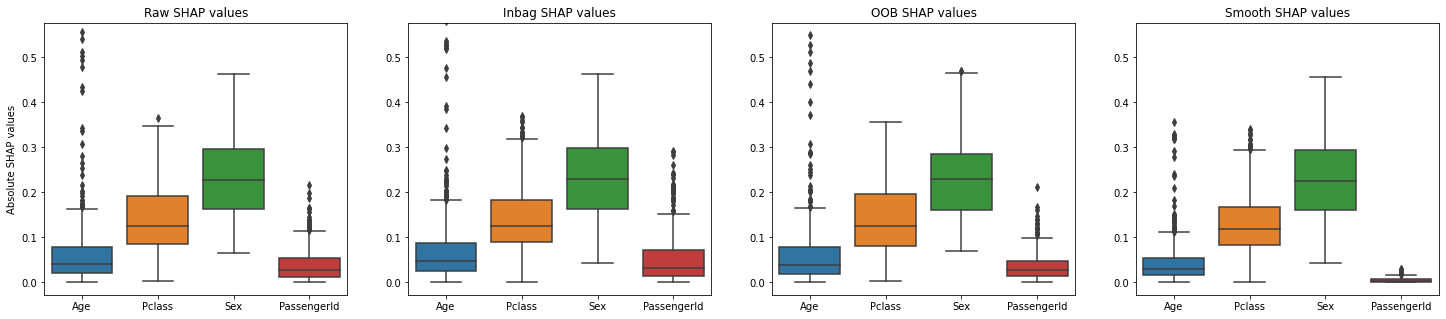

In [98]:
#Create boxplots
fig, axs = plt.subplots(1,4,figsize=(25,5))

sns.boxplot(data=np.abs(shap_vals_rf_raw), ax =axs[0])
sns.boxplot(data=np.abs(rf.inbag_SHAP_values), ax=axs[1])
sns.boxplot(data=np.abs(rf.oob_SHAP_values), ax=axs[2])
sns.boxplot(data=np.abs(smshap_vals), ax=axs[3])

axs[0].set_ylabel("Absolute SHAP values")
axs[0].set_title("Raw SHAP values")
axs[1].set_title("Inbag SHAP values")
axs[2].set_title("OOB SHAP values")
axs[3].set_title("Smooth SHAP values")

plt.setp(axs, xticks=[0, 1, 2, 3], xticklabels=X_train.columns)

plt.setp(axs, ylim=axs[2].get_ylim());

### Create SHAP beeswarmplots (global explanations)

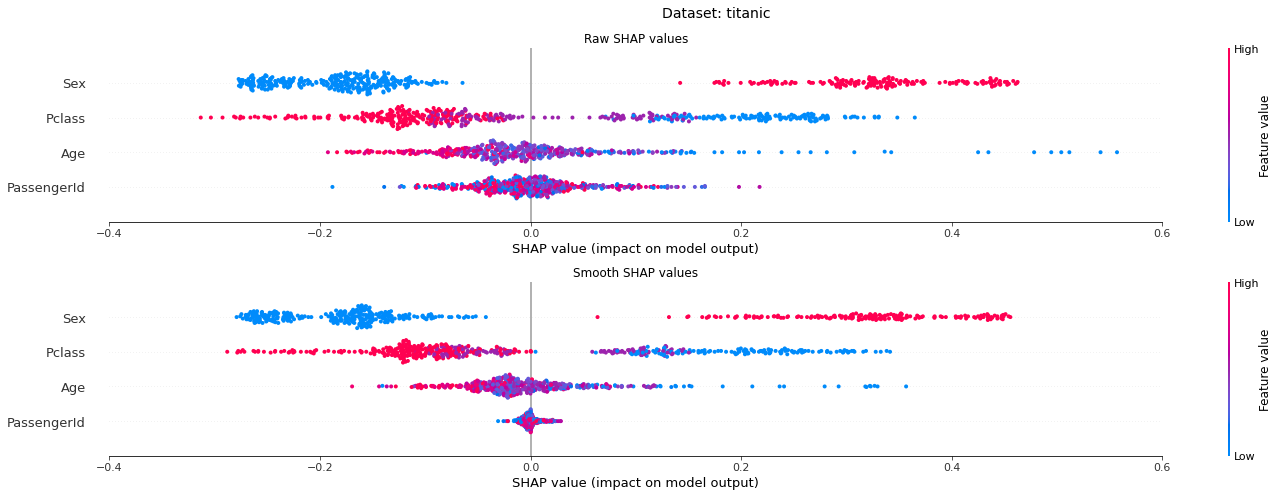

In [99]:
#Create SHAP beeswarm plots for raw SHAP and Smooth SHAP
fig = plt.figure()

#Raw SHAP vaues
ax0 = fig.add_subplot(211)
ax0.set_title("Raw SHAP values")
shap.summary_plot(shap_vals_rf_raw, X_train, X_train.columns, show=False)

#Smooth SHAP values
ax1 = fig.add_subplot(212)
ax1.set_title("Smooth SHAP values")
shap.summary_plot(smshap_vals, X_train, X_train.columns, show=False)

plt.gcf().set_size_inches(20,7)
plt.suptitle(f"Dataset: titanic", fontsize=14)
plt.setp([ax0, ax1], xlim=(-0.4, 0.6)) # set axis range for both plots
plt.tight_layout() 
plt.show()

### Identify observation with high raw SHAP value for PID, but low smooth SHAP value for PID

In [61]:
# Lets create a dataframe with SHAP raw PID and SHAP smooth PID
shap_raw_pid = shap_vals_rf_raw[:,3].reshape(-1,1) # raw SHAP fo PassengerID
sm_shap_pid = smshap_vals[:,3].reshape(-1,1) # Smooth SHAP fo PassengerID

df = pd.DataFrame(np.hstack((shap_raw_pid, sm_shap_pid)), columns=["shap_raw_pid", "sm_shap_pid"])

# Create additional columns to compare differences
df["diff"] = df["shap_raw_pid"]-df["sm_shap_pid"] 
df["diff_abs"] = df["shap_raw_pid"].abs()-df["sm_shap_pid"].abs()
df.head(3)

,shap_raw_pid,sm_shap_pid,diff,diff_abs
0,-0.050766,-0.004859,-0.045907,0.045907
1,-0.037505,-0.003656,-0.033849,0.033849
2,-0.038405,-0.006282,-0.032123,0.032123


In [80]:
# Row with absolute maximum difference between SHAP raw and SHAP smooth
max_idx = df["diff_abs"].idxmax()
df.iloc[[max_idx]]

,shap_raw_pid,sm_shap_pid,diff,diff_abs
387,0.217434,0.02879,0.188644,0.188644


In [82]:
# Row with maximum negatic difference between SHAP raw and SHAP smooth
max_neg_idx = df["diff"].idxmin()
df.iloc[[max_neg_idx]]

,shap_raw_pid,sm_shap_pid,diff,diff_abs
390,-0.188235,-0.030892,-0.157343,0.157343


### Create SHAP force plots (local explanations)

#### Observation with max absolute difference

In [70]:
# Raw SHAP values for observation
shap.force_plot(explainer_rf.expected_value, shap_vals_rf_raw[max_idx,:], features=X_train.iloc[max_idx])

To preserve local accuracy we rescale the smooth SHAP values before plotting

In [77]:
# Smooth SHAP values for observation (rescaled)
rescale_fac = np.sum(shap_vals_rf_raw[max_idx,:])/np.sum(smshap_vals[max_idx,:])
shap.force_plot(explainer_rf.expected_value, smshap_vals[max_idx,:]*rescale_fac, features=X_train.iloc[max_idx])

####

#### Observation with max negative difference

In [84]:
# Raw SHAP values for observation
shap.force_plot(explainer_rf.expected_value, shap_vals_rf_raw[max_neg_idx,:], features=X_train.iloc[max_neg_idx])

In [85]:
# Smooth SHAP values for observation (rescaled)
rescale_fac = np.sum(shap_vals_rf_raw[max_neg_idx,:])/np.sum(smshap_vals[max_neg_idx,:])
shap.force_plot(explainer_rf.expected_value, smshap_vals[max_neg_idx,:]*rescale_fac, features=X_train.iloc[max_neg_idx])

####